In [203]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import solve_ivp
import cmdstanpy
import seaborn as sns

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = (11, 7)


## SIR Model

S = susceptible, I = infected, R = recovered

\begin{align}
    \frac{dS}{dt} &= -\beta SI \\
    \frac{dI}{dt} &= \beta SI - \gamma I \\
    \frac{dR}{dt} &= \gamma I \\
\end{align}

where parameters $\beta$ is the transmission rate and $\gamma$ is the recovery rate, and $S + I + R = 1$.

In [14]:
def SIR(t, y, beta, gamma):
    # y = S, I, R
    dSdt = - beta * y[0] * y[1]
    dIdt = beta * y[0] * y[1] - gamma * y[1]
    dRdt = gamma * y[1]
    return np.array([dSdt, dIdt, dRdt])

## Simulate some data 

In [339]:
# initial conditions
I0 = 0.05
S0 = 1 - I0
R0 = 0
init = (S0, I0, R0)

# parameters
beta = 0.5
gamma = 0.05

# time boundaries
ti = 0
tf = 100

In [340]:
sol = solve_ivp(SIR, [ti, tf], init, args=(beta, gamma), first_step=1, max_step=1)
sol.success

True

Text(0, 0.5, '% of population')

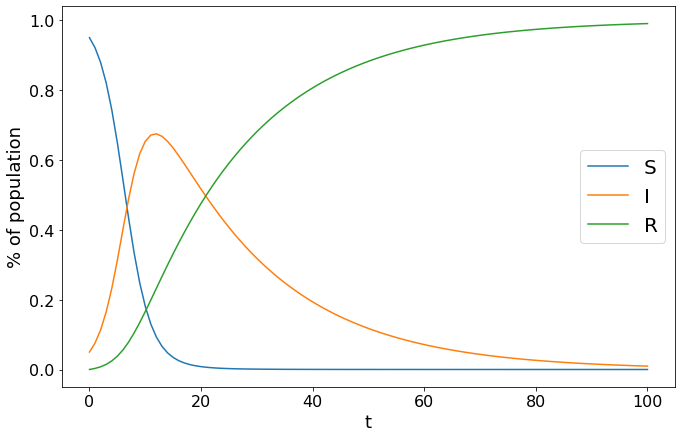

In [341]:
plt.plot(sol.t, sol.y[0], label='S')
plt.plot(sol.t, sol.y[1], label='I')
plt.plot(sol.t, sol.y[2], label='R')
plt.legend(fontsize=20)
plt.xlabel('t')
plt.ylabel('% of population')

## Randomly sample some binomial data with noise

In [344]:
sample_days = 25 # number of data points
sample_n = 25 # number of people sampled per day
sample_times = np.random.choice(sol.t, size=sample_days, replace=False) # only sampled during these days
sample_true_i = sol.y[1][sample_times.astype(int)] # true % infected on sampled days
sample_i = np.random.binomial(sample_n, sample_true_i, size=sample_days) # binomial error on measurements

sortidx = np.argsort(sample_times)
sample_times = sample_times[sortidx]
sample_i = sample_i[sortidx]

Text(0, 0.5, '% of population')

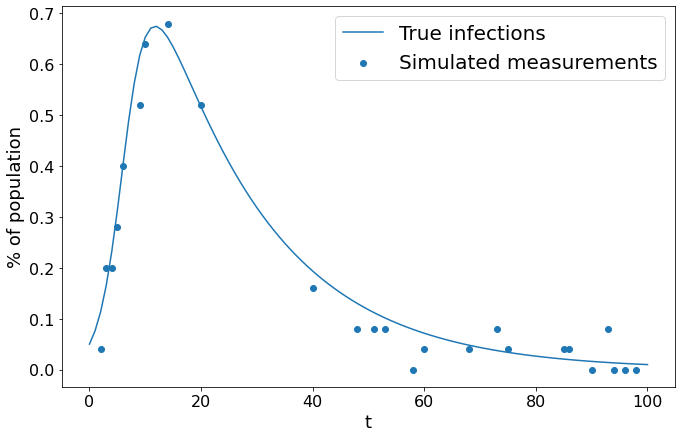

In [345]:
plt.scatter(sample_times, sample_i / sample_n, label='Simulated measurements')
plt.plot(sol.t, sol.y[1], label='True infections')
plt.legend(fontsize=20)
plt.xlabel('t')
plt.ylabel('% of population')

## Build Stan model (see `model.stan` for more details) 

In [346]:
sm = cmdstanpy.CmdStanModel(stan_file='model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/js/programs/stan-ode-example/model


In [347]:
# tell stan to make predictions at these times
t_pred = np.arange(100)

In [348]:
standata = dict(
    n_obs = sample_days,
    n_sample = sample_n,
    n_eq = 3,
    t0 = 0.,
    t_obs = sample_times,
    y_obs = sample_i,
    n_gen = t_pred[1:].size,
    t_gen = t_pred[1:] # don't need to pass t0
)

## Run model

In [349]:
fit = sm.sample(data=standata, show_progress='notebook')

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

## Check results

In [350]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmpbghuqw5y/model-202107181716-1-2bvw_wwc.csv, /tmp/tmpbghuqw5y/model-202107181716-2-ew8hvfr7.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /tmp/tmpbghuqw5y/model-202107181716-1-2bvw_wwc.csv, /tmp/tmpbghuqw5y/model-202107181716-2-ew8hvfr7.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [351]:
outputs = fit.stan_variables()

beta_pred = outputs['p_beta']
gamma_pred = outputs['p_gamma']
i0_pred = outputs['I0']
y_gen = outputs['y_gen']

In [371]:
s0_pred = 1 - i0_pred
r0_pred = np.zeros_like(i0_pred)

s_pred = np.hstack((s0_pred.reshape(-1, 1), y_gen[:,:,0]))
i_pred = np.hstack((i0_pred.reshape(-1, 1), y_gen[:,:,1]))
r_pred = np.hstack((r0_pred.reshape(-1, 1), y_gen[:,:,2]))

## Initial output plotting 

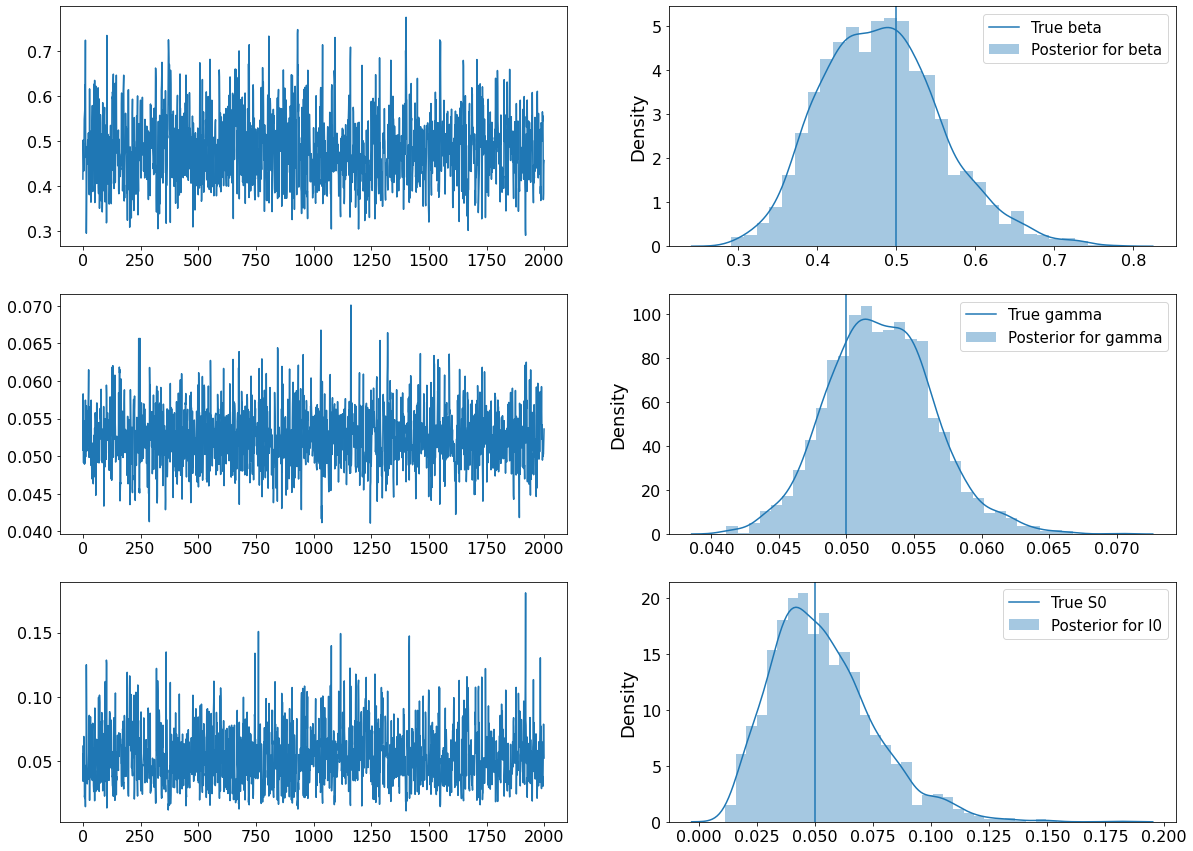

In [352]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

# plot traceplots
ax[0,0].plot(beta_pred)
ax[1,0].plot(gamma_pred)
ax[2,0].plot(i0_pred)

# plot posteriors
sns.distplot(beta_pred, ax=ax[0,1], label='Posterior for beta')
sns.distplot(gamma_pred, ax=ax[1,1], label='Posterior for gamma')
sns.distplot(i0_pred, ax=ax[2,1], label='Posterior for I0')

# plot true parameters
ax[0,1].axvline(beta, label='True beta')
ax[1,1].axvline(gamma, label='True gamma')
ax[2,1].axvline(I0, label='True S0')

for i in range(3):
    ax[i,1].legend(fontsize=15)

## Check predictions

Text(0, 0.5, '% of population')

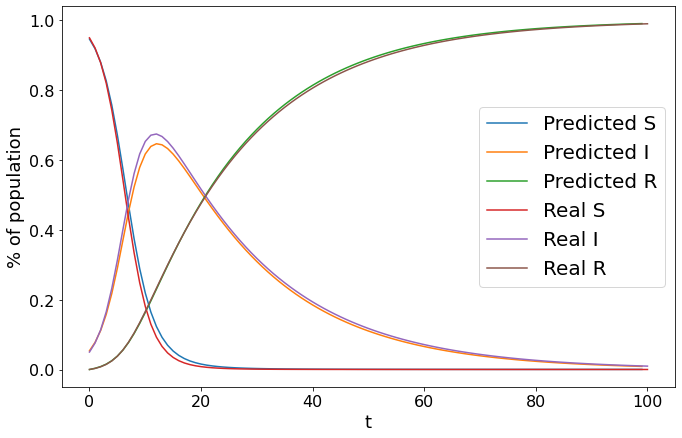

In [377]:

plt.plot(t_pred, s_pred.mean(axis=0), label='Predicted S')
plt.plot(t_pred, i_pred.mean(axis=0), label='Predicted I')
plt.plot(t_pred, r_pred.mean(axis=0), label='Predicted R')

plt.plot(sol.t, sol.y[0], label='Real S')
plt.plot(sol.t, sol.y[1], label='Real I')
plt.plot(sol.t, sol.y[2], label='Real R')

plt.legend(fontsize=20)

plt.xlabel('t')
plt.ylabel('% of population')

Text(0, 0.5, '% of population')

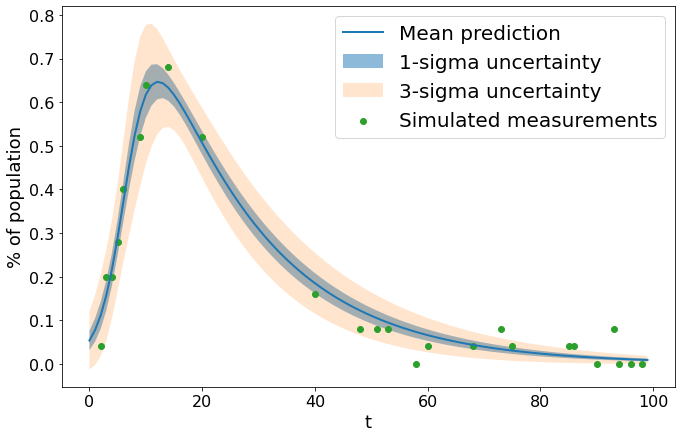

In [374]:
plt.fill_between(t_pred, i_pred.mean(axis=0) - i_pred.std(axis=0), i_pred.mean(axis=0) + i_pred.std(axis=0), alpha=0.5, label='1-sigma uncertainty')
plt.fill_between(t_pred, i_pred.mean(axis=0) - 3 * i_pred.std(axis=0), i_pred.mean(axis=0) + 3 * i_pred.std(axis=0), alpha=0.2, label='3-sigma uncertainty')
plt.scatter(sample_times, sample_i / sample_n, label='Simulated measurements')
plt.plot(t_pred, i_pred.mean(axis=0), lw=2, label='Mean prediction')

plt.legend(fontsize=20)
plt.xlabel('t')
plt.ylabel('% of population')

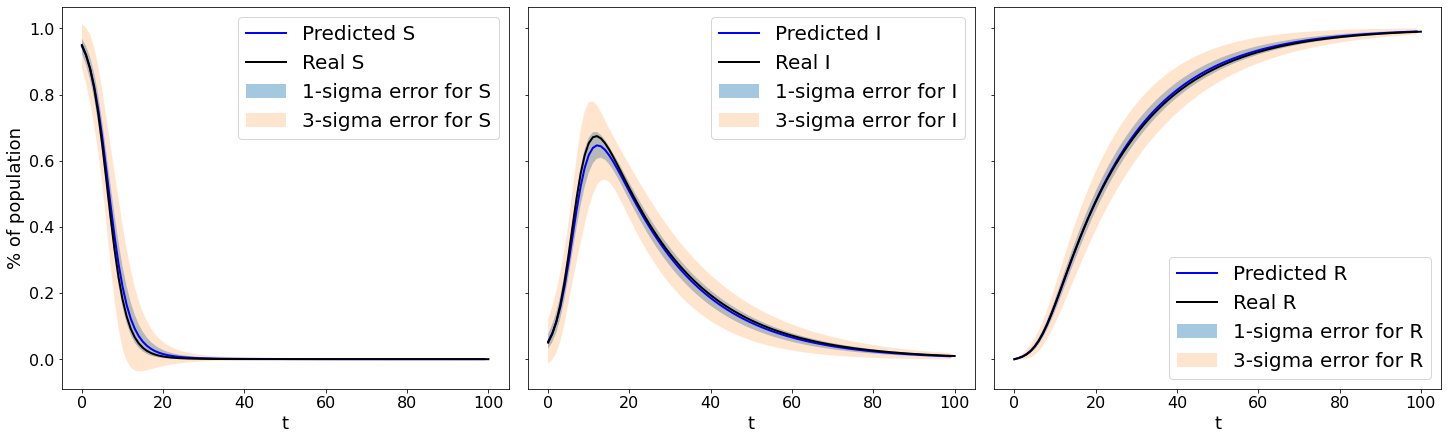

In [390]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True, constrained_layout=True)


ax[0].fill_between(t_pred, s_pred.mean(axis=0) - s_pred.std(axis=0), s_pred.mean(axis=0) + s_pred.std(axis=0), alpha=0.4, label='1-sigma error for S')
ax[1].fill_between(t_pred, i_pred.mean(axis=0) - i_pred.std(axis=0), i_pred.mean(axis=0) + i_pred.std(axis=0), alpha=0.4, label='1-sigma error for I')
ax[2].fill_between(t_pred, r_pred.mean(axis=0) - r_pred.std(axis=0), r_pred.mean(axis=0) + r_pred.std(axis=0), alpha=0.4, label='1-sigma error for R')

ax[0].fill_between(t_pred, s_pred.mean(axis=0) - 3 * s_pred.std(axis=0), s_pred.mean(axis=0) + 3 * s_pred.std(axis=0), alpha=0.2, label='3-sigma error for S')
ax[1].fill_between(t_pred, i_pred.mean(axis=0) - 3 * i_pred.std(axis=0), i_pred.mean(axis=0) + 3 * i_pred.std(axis=0), alpha=0.2, label='3-sigma error for I')
ax[2].fill_between(t_pred, r_pred.mean(axis=0) - 3 * r_pred.std(axis=0), r_pred.mean(axis=0) + 3 * r_pred.std(axis=0), alpha=0.2, label='3-sigma error for R')

ax[0].plot(t_pred, s_pred.mean(axis=0), lw=2, c='b', label='Predicted S')
ax[1].plot(t_pred, i_pred.mean(axis=0), lw=2, c='b', label='Predicted I')
ax[2].plot(t_pred, r_pred.mean(axis=0), lw=2, c='b', label='Predicted R')

ax[0].plot(sol.t, sol.y[0], c='k', lw=2, label='Real S')
ax[1].plot(sol.t, sol.y[1], c='k', lw=2, label='Real I')
ax[2].plot(sol.t, sol.y[2], c='k', lw=2, label='Real R')

ax[0].set_ylabel('% of population')

for i in range(3):
    ax[i].set_xlabel('t')
    ax[i].legend(fontsize=20)